In [2]:
# ref https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('../../data/data/names/*.txt'))

import unicodedata
import string


['../../data/data/names/Russian.txt', '../../data/data/names/Polish.txt', '../../data/data/names/Greek.txt', '../../data/data/names/Spanish.txt', '../../data/data/names/Dutch.txt', '../../data/data/names/Czech.txt', '../../data/data/names/French.txt', '../../data/data/names/Korean.txt', '../../data/data/names/Arabic.txt', '../../data/data/names/Chinese.txt', '../../data/data/names/Vietnamese.txt', '../../data/data/names/Italian.txt', '../../data/data/names/Scottish.txt', '../../data/data/names/German.txt', '../../data/data/names/Portuguese.txt', '../../data/data/names/English.txt', '../../data/data/names/Japanese.txt', '../../data/data/names/Irish.txt']


In [1]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))
print(unicodeToAscii('abc123'))

NameError: name 'string' is not defined

In [23]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../../data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print("Categories: ",n_categories,all_categories)


18
['Russian', 'Polish', 'Greek', 'Spanish', 'Dutch', 'Czech', 'French', 'Korean', 'Arabic', 'Chinese', 'Vietnamese', 'Italian', 'Scottish', 'German', 'Portuguese', 'English', 'Japanese', 'Irish']


## Turning Names into Tensors

In [29]:
import torch
print("string.ascii_letters: ",string.ascii_letters)
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('a'))
print(letterToTensor('b'))
print(lineToTensor('Jones').size())

string.ascii_letters:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Creating the networks

In [30]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [31]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

print(output)

tensor([[-2.9073, -2.9047, -2.8982, -2.8581, -2.9223, -2.8202, -2.8555, -2.8799,
         -2.8559, -2.9068, -2.8993, -2.8031, -2.9246, -2.9992, -2.8870, -2.9488,
         -2.9329, -2.8422]], grad_fn=<LogSoftmaxBackward0>)


In [33]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(output.topk(1))

tensor([[-2.9073, -2.9047, -2.8982, -2.8581, -2.9223, -2.8202, -2.8555, -2.8799,
         -2.8559, -2.9068, -2.8993, -2.8031, -2.9246, -2.9992, -2.8870, -2.9488,
         -2.9329, -2.8422]], grad_fn=<LogSoftmaxBackward0>)
torch.return_types.topk(
values=tensor([[-2.8031]], grad_fn=<TopkBackward0>),
indices=tensor([[11]]))


In [40]:
#['Russian', 'Polish', 'Greek', 'Spanish', 'Dutch', 'Czech', 'French', 'Korean',
# 'Arabic', 'Chinese', 'Vietnamese', 'Italian', 'Scottish', 'German', 'Portuguese',
# 'English', 'Japanese', 'Irish']
output = torch.tensor([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))
print(output)



('Russian', 0)
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [51]:
import random
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]
print(randomChoice(all_categories))

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
print(category_lines["Chinese"])

for i in range(3):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)



Russian
['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao', 'Cen', 'Chai', 'Chaim', 'Chan', 'Chang', 'Chao', 'Che', 'Chen', 'Cheng', 'Cheung', 'Chew', 'Chieu', 'Chin', 'Chong', 'Chou', 'Chu', 'Cui', 'Dai', 'Deng', 'Ding', 'Dong', 'Dou', 'Duan', 'Eng', 'Fan', 'Fei', 'Feng', 'Foong', 'Fung', 'Gan', 'Gauk', 'Geng', 'Gim', 'Gok', 'Gong', 'Guan', 'Guang', 'Guo', 'Gwock', 'Han', 'Hang', 'Hao', 'Hew', 'Hiu', 'Hong', 'Hor', 'Hsiao', 'Hua', 'Huan', 'Huang', 'Hui', 'Huie', 'Huo', 'Jia', 'Jiang', 'Jin', 'Jing', 'Joe', 'Kang', 'Kau', 'Khoo', 'Khu', 'Kong', 'Koo', 'Kwan', 'Kwei', 'Kwong', 'Lai', 'Lam', 'Lang', 'Lau', 'Law', 'Lew', 'Lian', 'Liao', 'Lim', 'Lin', 'Ling', 'Liu', 'Loh', 'Long', 'Loong', 'Luo', 'Mah', 'Mai', 'Mak', 'Mao', 'Mar', 'Mei', 'Meng', 'Miao', 'Min', 'Ming', 'Moy', 'Mui', 'Nie', 'Niu', 'OuYang', 'OwYang', 'Pan', 'Pang', 'Pei', 'Peng', 'Ping', 'Qian', 'Qin', 'Qiu', 'Quan', 'Que', 'Ran', 'Rao', 'Rong', 'Ruan', 'Sam', 'Seah', 'See ', 'Seow', 'Seto', 'Sha', 'Sh

# Train network:

In [37]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [55]:
import time
import math

n_iters = 1000000
print_every = 5000
plot_every = 1000

# n_iters = 100
# print_every = 20
# plot_every = 10

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 0% (0m 6s) 2.0169 Lachapelle / Scottish ✗ (French)
10000 1% (0m 13s) 1.8566 Mcmahon / Korean ✗ (Irish)
15000 1% (0m 20s) 3.9036 Skwor / Korean ✗ (Czech)
20000 2% (0m 26s) 0.6860 Schuhart / German ✓
25000 2% (0m 32s) 0.6875 Deeb / Arabic ✓
30000 3% (0m 39s) 1.4182 Santiago / Portuguese ✗ (Spanish)
35000 3% (0m 46s) 0.1202 Damhain / Irish ✓
40000 4% (0m 53s) 0.3551 Schrijnemakers / Dutch ✓
45000 4% (1m 0s) 0.0105 Stawski / Polish ✓
50000 5% (1m 7s) 0.7904 Lau / Vietnamese ✗ (Chinese)
55000 5% (1m 13s) 1.5490 Brady / Scottish ✗ (Irish)
60000 6% (1m 20s) 1.1480 Uhlik / Russian ✗ (Czech)
65000 6% (1m 27s) 3.0213 Napier / French ✗ (English)
70000 7% (1m 33s) 1.9026 Lucas / Greek ✗ (English)
75000 7% (1m 40s) 3.5727 Wellington / Scottish ✗ (English)
80000 8% (1m 47s) 3.1469 Krivan / English ✗ (Czech)
85000 8% (1m 54s) 0.2872 Moon / Korean ✓
90000 9% (2m 1s) 0.0185 Koutsoubos / Greek ✓
95000 9% (2m 7s) 1.2842 Demetrious / Portuguese ✗ (Greek)
100000 10% (2m 14s) 1.3645 Mikhail / Russian ✗

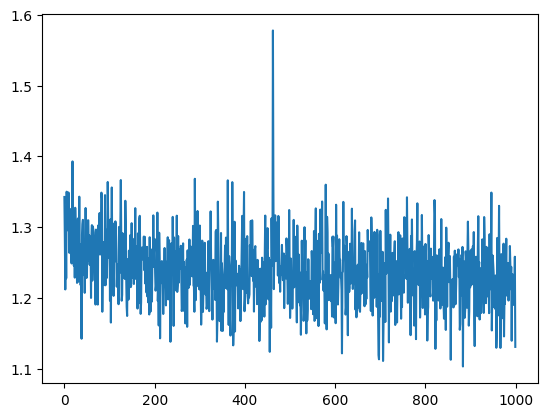

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_507686/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_507686/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


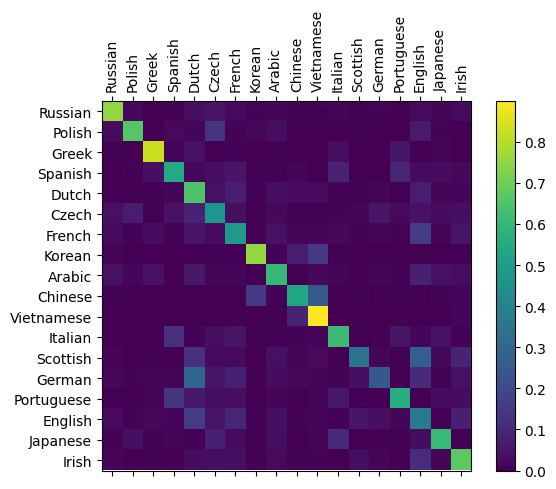

In [58]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [69]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Jack')
predict('jack')
predict('zhiqiang')
predict('tang')
predict('Tan')
predict('Kin')


> Dovesky
(-0.25) Russian
(-2.05) Czech
(-3.06) English

> Jackson
(-1.06) English
(-1.81) Scottish
(-1.81) Dutch

> Satoshi
(-1.16) Italian
(-1.18) Arabic
(-2.21) Japanese

> Jack
(-1.08) Czech
(-1.79) English
(-2.08) Dutch

> jack
(-0.44) Dutch
(-1.34) Czech
(-3.48) German

> zhiqiang
(-1.24) English
(-1.31) Scottish
(-2.28) Czech

> tang
(-1.63) German
(-1.76) Vietnamese
(-1.83) English

> Tan
(-0.48) Vietnamese
(-1.00) Chinese
(-4.85) Korean

> Kin
(-1.21) Chinese
(-1.37) Vietnamese
(-1.91) Russian
